In [2]:
import xarray as xr, matplotlib, matplotlib.pyplot as plt, glob, os, re, geopandas as gpd, regionmask, cartopy, pandas as pd, numpy as np
matplotlib.rcParams['savefig.bbox'] = "tight"    # always save with tight bounding box
from IPython.display import clear_output
from IPython.display import clear_output
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/SEAsiaFloods/"
mapproj = cartopy.crs.PlateCarree()

ERROR 1: PROJ: proj_create_from_database: Open of /rds/general/user/cb2714/home/miniforge3/envs/wwa/share/proj failed


# Seasonal cycle

In [2]:
rnm = "SumatraMalayThai-LAND" # "SriLanka"

ds_list = ["era5", "mswep", "chirps", "cpc"]

sc_obs = xr.concat([xr.open_dataset("data/ts-daily_"+ds_nm+"_"+rnm+".nc").sel(time = slice("1990","2020")).groupby("time.dayofyear").mean().pr.expand_dims(ds = [ds_nm]) for ds_nm in ds_list], "ds").to_pandas().transpose()

fl = sorted(glob.glob("data/pr_"+rnm+"*.nc"))

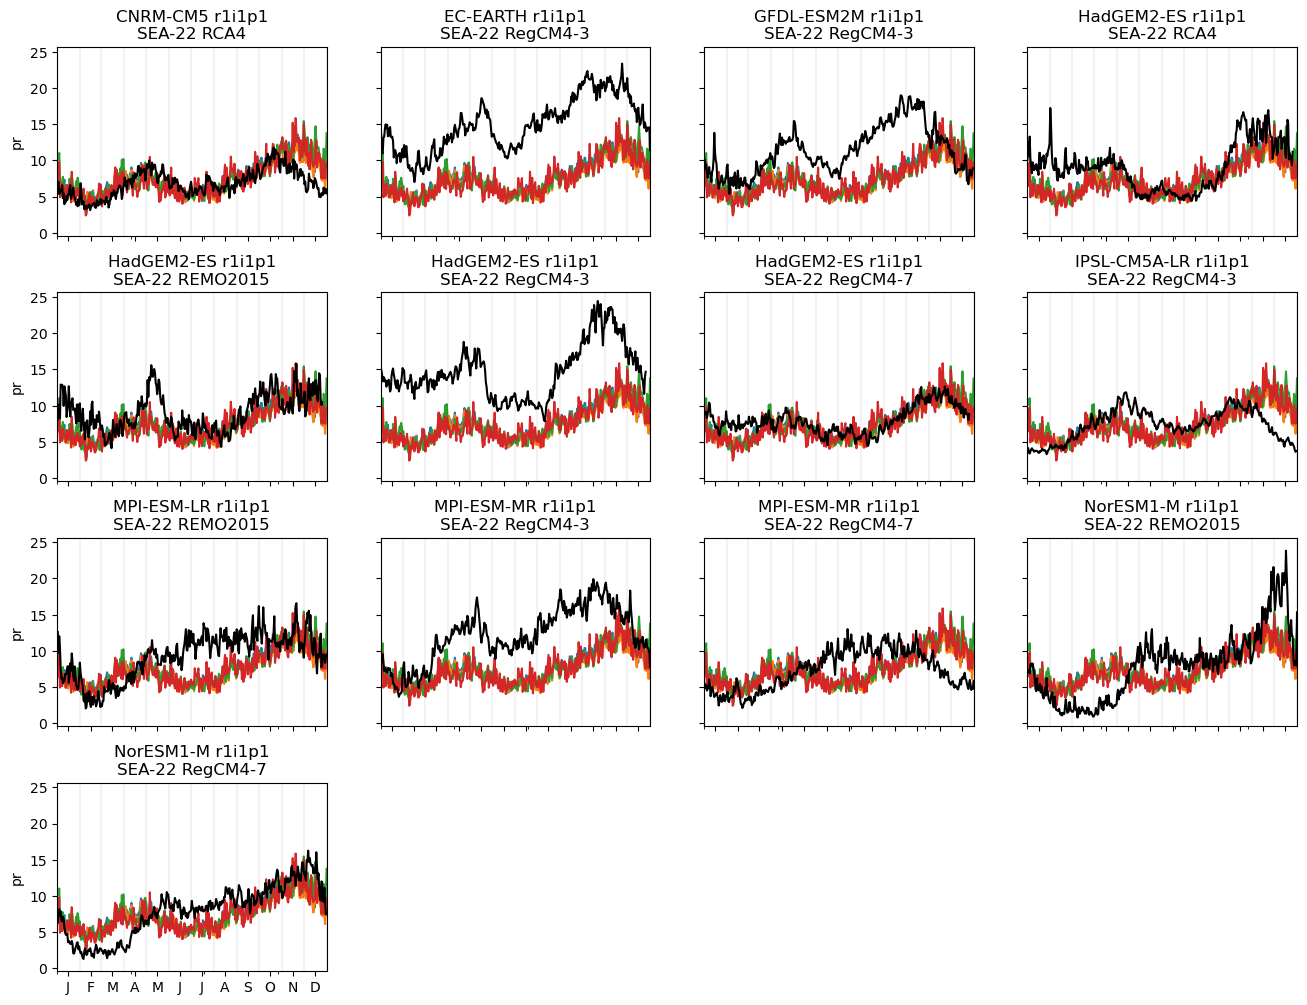

In [39]:
nc = {"SriLanka" : 6, "SumatraMalayThai-LAND" : 4}[rnm]
nr = int(np.ceil(len(fl) / nc))

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 4, nr * 3), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.3)

for i in range(len(fl)):
    ax = axs.flatten()[i]
    fnm = fl[i]
    sc = xr.open_dataset(fnm).pr.sel(time = slice("1990","2020")).groupby("time.dayofyear").mean()

    sc_obs.plot(ax = ax, legend = None)
    sc.plot(ax = ax, color = "k", label = "model")

    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
    ax.margins(x = 0)

    ax.set_title(" ".join(fnm.split("_")[3:5])+"\n"+fnm.split("_")[2]+" "+fnm.split("_")[-2])
    ax.set_xlabel("")

for i in range(len(fl), nc*nr):  axs.flatten()[i].set_axis_off()
plt.savefig("fig/mdl-eval_seasonal-cycle_"+rnm+"_cordex")


# Spatial pattern

## Spatial patterns for obs

In [ ]:
for ds_nm in ["era5CDSClimExp", "mswep", "cpc", "chirps"]:

    fnm = fpath+ds_nm+"_SEAsia.nc"
    new_fnm = "data/pr-ond_"+re.sub("CDSClimExp","",ds_nm)+".nc"
    if os.path.exists(new_fnm): continue
    
    # use CDO to get monthly means because python seems unable to do so
    ! module load CDO/2.4.4-gompi-2024a; cdo -monavg -selmon,10,11,12 -selyear,1990/2020 $fnm $new_fnm

## Spatial pattern maps for models

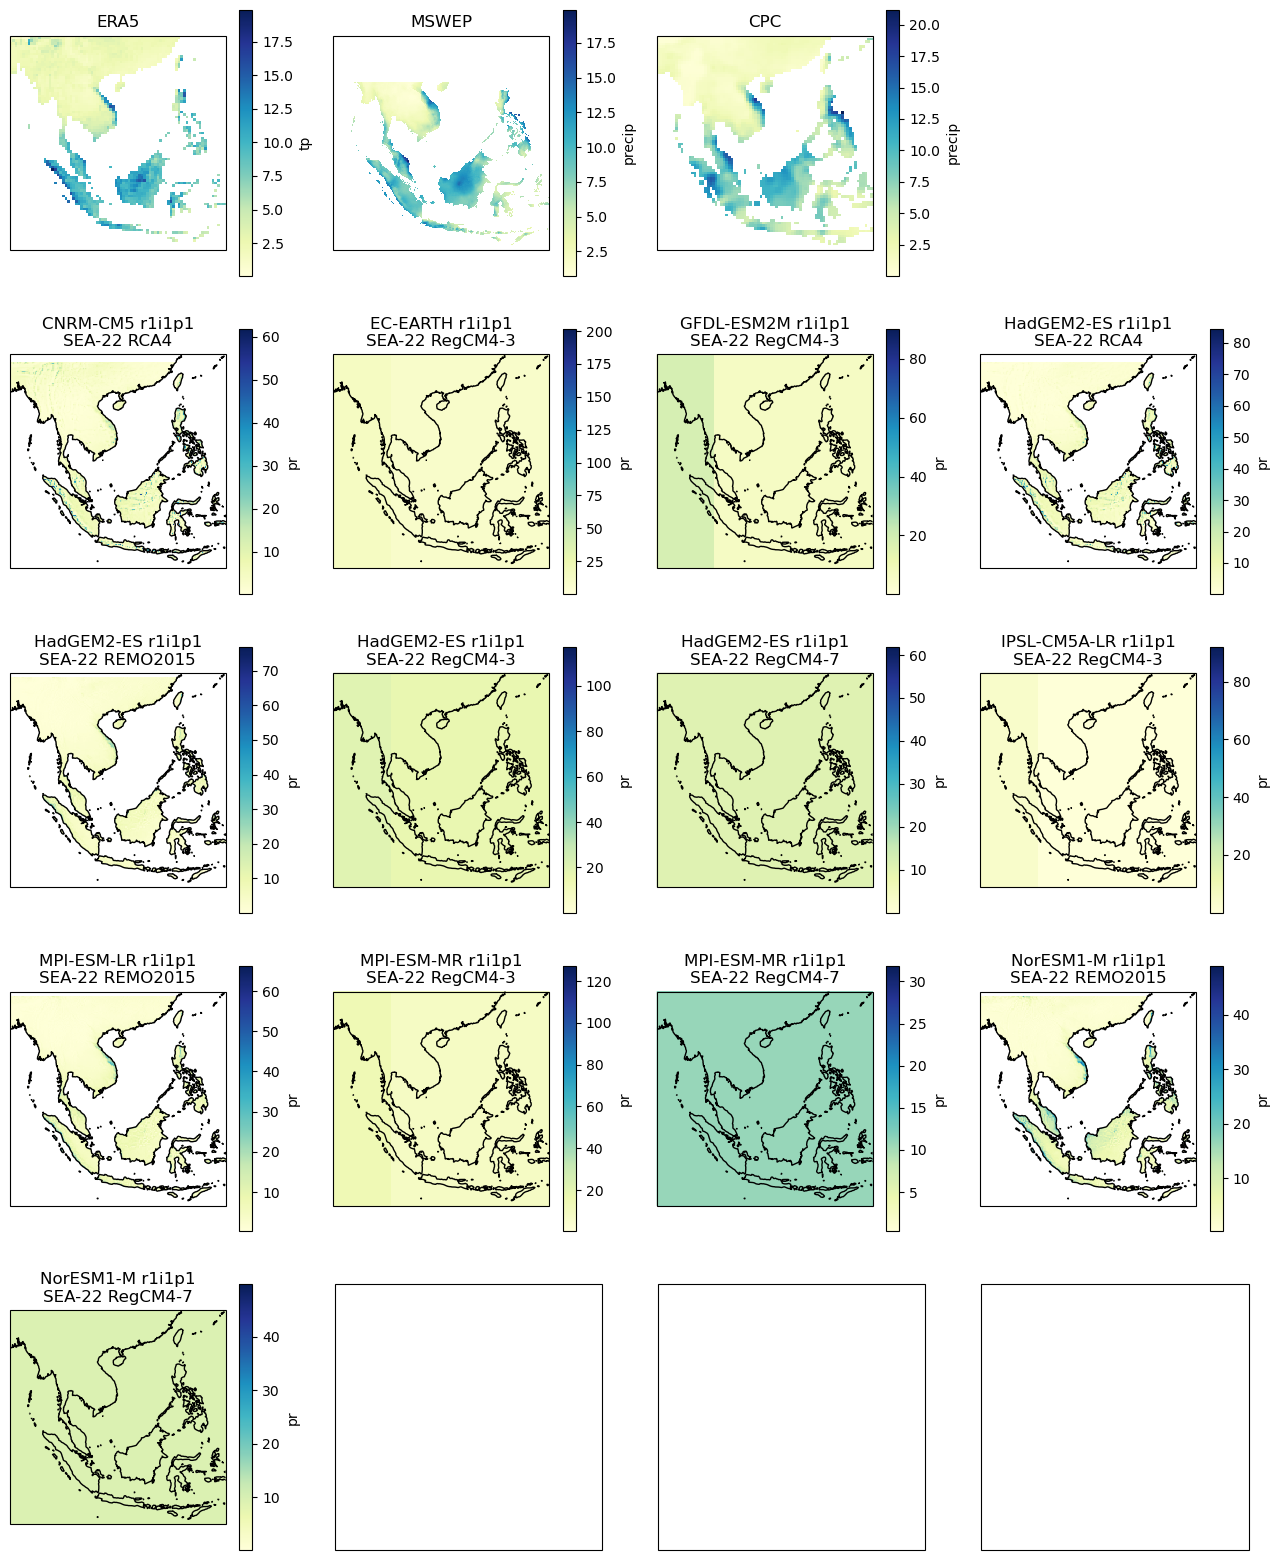

In [7]:
rnm = "SumatraMalayThai-LAND"

nc = {"SriLanka" : 6, "SumatraMalayThai-LAND" : 4}[rnm]
domain = {"SriLanka" : "WAS", "SumatraMalayThai-LAND" : "SEA"}[rnm]
extent = {"SriLanka" : [], "SumatraMalayThai-LAND" : [89,130,-11.4, 27.3]}[rnm]

# list models & set up figures
fl = sorted(glob.glob(fpath+"pr-cordex/*"+domain+"*.nc"))

# plot attributes
nmod = len(fl)
nr = int(np.ceil(nmod / nc))+1

cbar_kwargs = {"shrink" : 0.9}

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 4, nr * 4), dpi = 100, sharex = True, sharey = True, subplot_kw = {"projection" : mapproj, "extent" : extent})
plt.subplots_adjust(hspace = 0.2)

ds_list = ["era5", "mswep", "cpc"]
for i in range(len(ds_list)):
    ds_nm = ds_list[i]
    ax = axs[0,i]
    sp = xr.open_dataset("data/pr-ond_"+ds_nm+".nc").mean("time")
    sp = sp[list(sp.data_vars)[0]]
    sp.plot(ax = ax, cmap = "YlGnBu")
    ax.set_title(ds_nm.upper())
for i in range(len(ds_list), nc): axs[0,i].set_axis_off()

for i in range(len(fl)):
    ax = axs.flatten()[nc+i]
    fnm = fl[i]

    mdl = " ".join(fnm.split("_")[3:5])+"\n"+fnm.split("_")[2]+" "+fnm.split("_")[-2]

    ds = xr.open_dataset(fnm).pr.sel(time = slice("1990","2020"))
    sp = ds.sel(time = ds.time.dt.month.isin([10,11,12])).mean("time")

    rm = regionmask.defined_regions.natural_earth_v5_1_2.land_50.mask(sp.lon, sp.lat)
    sp = sp.where(rm == 0)

    sp.plot(ax = ax, cmap = "YlGnBu")
    ax.coastlines()
    ax.set_title(" ".join(fnm.split("_")[-4:-2])+"\n"+fnm.split("_")[-5]+" "+fnm.split("_")[-2])

plt.savefig("fig/mdl-eval_spatial-pattern_"+rnm+"_cordex")

# Make time series for ClimExp

## rx5day

In [12]:
for rnm in ["SriLanka", "SumatraMalayThai-LAND"]:
    fl = [fnm for fnm in sorted(glob.glob("data/pr_"+rnm+"_*.nc")) if not "_highresSST" in fnm]

    short_rnm = {"SriLanka" : "SL", "SumatraMalayThai-LAND": "SMT"}[rnm]
    
    for fnm in fl:
        
        mdl = "_".join(fnm.split("_")[2:6])

        # tweaks to shorten filename
        mdl = re.sub("COSMO-crCLIM-v1-1", "COSMO", mdl)

        csv_fnm = "SEA-floods_rx5day-"+short_rnm+"_"+mdl
        csv_fullpath = "ts-dat/"+csv_fnm+".dat"
        if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

        print(csv_fnm)

        if os.path.exists(csv_fnm): continue

        # create header lines for upload to Climate Explorer 
        str1 = "# contact :: CORDEX "+re.sub("_"," ",mdl)+" rx5day - "+short_rnm+" - SE Asia floods, 2025, c.barnes22@imperial.ac.uk"
        str2 = "# rx5day [mm/day] annual maximum of 5-day accumulated rainfall averaged over "+rnm+" at "+csv_fnm+".dat"
        head = "# year rx5day"

        # make .dat file
        ! echo "$str1 " > $csv_fullpath
        ! echo "$str2" >> $csv_fullpath
        ! echo "$head" >> $csv_fullpath

        ts = xr.open_dataset(fnm).pr
        rx5day = ts.rolling(time = 5).sum().resample(time = "YS-JUL").max()
        rx5day = rx5day.assign_coords(time = rx5day.time.dt.year).rename(time = "year").to_dataframe()
        rx5day.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

    clear_output(wait = False)
print("Done.")

Done.


In [8]:
for rnm in ["SriLanka", "SumatraMalayThai-LAND"]:
    fl = sorted(glob.glob("data/pr_"+rnm+"_highresSST_*.nc"))

    short_rnm = {"SriLanka" : "SL", "SumatraMalayThai-LAND": "SMT"}[rnm]
    
    for fnm in fl:

        mdl = "_".join(fnm.split("_")[2:6])

        # tweaks to shorten filename
        mdl = re.sub("COSMO-crCLIM-v1-1", "COSMO", mdl)

        csv_fnm = "SEA-floods_rx5day-"+short_rnm+"_"+mdl
        csv_fullpath = "ts-dat/"+csv_fnm+".dat"
        if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

        print(csv_fnm)

        if os.path.exists(csv_fnm): continue

        # create header lines for upload to Climate Explorer 
        str1 = "# contact :: HighResMIP "+re.sub("_"," ",mdl)+" rx5day - "+short_rnm+" - SE Asia floods, 2025, c.barnes22@imperial.ac.uk"
        str2 = "# rx5day [mm/day] annual maximum of 5-day accumulated rainfall averaged over "+rnm+" at "+csv_fnm+".dat"
        head = "# year rx5day"

        # make .dat file
        ! echo "$str1 " > $csv_fullpath
        ! echo "$str2" >> $csv_fullpath
        ! echo "$head" >> $csv_fullpath

        ts = xr.open_dataset(fnm).pr
        if ts.max() < 1: ts = ts * 86400
        rx5day = ts.rolling(time = 5).sum().resample(time = "YS-JUL").max()
        rx5day = rx5day.assign_coords(time = rx5day.time.dt.year).rename(time = "year").to_dataframe()
        rx5day.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

    clear_output(wait = False)
print("Done.")

Done.


## IOD

In [91]:
# list all GCMs for which IOD is required (SE Asia only, not needed for Sri Lanka)
fl = glob.glob("ts-dat/*_SEA-*")
mlist = list(set(["_".join(fnm.split("_")[3:5]) for fnm in fl]))

for gcm in mlist:
    print(gcm)

    iod_fnm = glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/cmip5-iod/*"+re.sub("_", "_historical_", gcm)+"*.nc")
    if len(iod_fnm) == 0:
        print("No IOD found")
        continue

    # load IOD and extract annual time series
    iod = xr.open_dataset(iod_fnm[0]).tos.sel(time = slice(None, "2070"))
    iod_son = iod.sel(time = iod.time.dt.month.isin([9,10,11])).resample(time = "YS").mean()
    iod_son = iod_son.assign_coords(time = iod_son.time.dt.year).rename("iod", time = "year").to_dataframe()

    csv_fnm = "SEA-floods_iod-son_"+gcm
    csv_fullpath = "ts-dat/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: CMIP5 IOD-SON "+gcm+" - SE Asia floods, 2025, c.barnes22@imperial.ac.uk"
    str2 = "# iod [degC] September-November mean of IOD (difference between mean SSTs over 49E,71E,11S,11N and 89E,111E,11S,1N) at "+csv_fnm+".dat"
    head = "# year iod"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    iod_son.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

CNRM-CM5_r1i1p1
HadGEM2-ES_r1i1p1
EC-EARTH_r1i1p1
MPI-ESM-MR_r1i1p1
NorESM1-M_r1i1p1
MPI-ESM-LR_r1i1p1
GFDL-ESM2M_r1i1p1
No IOD found
IPSL-CM5A-LR_r1i1p1


/var/tmp/pbs.1222328.pbs-7/ipykernel_998553/2779091014.py:14: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  iod = xr.open_dataset(iod_fnm[0]).tos.sel(time = slice(None, "2070"))


## ENSO

In [114]:
# list all GCMs for which IOD is required (SE Asia only, not needed for Sri Lanka)
fl = glob.glob("ts-dat/*_SEA-*")
mlist = list(set(["_".join(fnm.split("_")[3:5]) for fnm in fl]))

for gcm in mlist:
    print(gcm)

    iod_fnm = glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/cmip5-nino34/*"+gcm+"*")
    if len(iod_fnm) == 0:
        print("No Nino3.4 found")
        continue

    # load IOD and extract annual time series
    nino34 = xr.open_dataset(iod_fnm[0]).sel(time = slice(None, "2070")).nino34_det
    nino34_son = nino34.sel(time = nino34.time.dt.month.isin([9,10,11])).resample(time = "YS").mean()
    nino34_son = nino34_son.assign_coords(time = nino34_son.time.dt.year).rename("nino34", time = "year").to_dataframe()

    csv_fnm = "SEA-floods_nino34-son_"+gcm
    csv_fullpath = "ts-dat/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: CMIP5 Nino34-SON "+gcm+" - SE Asia floods, 2025, c.barnes22@imperial.ac.uk"
    str2 = "# nino34 [degC] September-November mean of Nino34 (difference between mean SSTs over 170W,120W,5S,5N and 20S,20N) at "+csv_fnm+".dat"
    head = "# year nino34"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    nino34_son.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

CNRM-CM5_r1i1p1
HadGEM2-ES_r1i1p1
EC-EARTH_r1i1p1
No Nino3.4 found
MPI-ESM-MR_r1i1p1
NorESM1-M_r1i1p1
MPI-ESM-LR_r1i1p1
GFDL-ESM2M_r1i1p1
IPSL-CM5A-LR_r1i1p1
No Nino3.4 found
